# Poisson spiking basics


Here we are dealing with homogeneous Poisson processes. See http://www.cns.nyu.edu/~david/handouts/poisson.pdf for an excellent introduction to Poisson processes relevant to neuroscience.

Spikes are irregular. A wildely used model for spike trains is a Poisson spike train. The spiking is controlled by a single rate parameter, $r(t)$. For a 'homogeneous' Poisson proces $r(t)$, and thus the spike rate, is constant. The probability of 'no spike' obeys  

$$\frac{dp_o}{dt} = -rp_o$$ 

The interspike interval (isi) is therefore exponentially distributed with density function:

$$ p_o(t) = re^{-rt}$$

The mean isi is then:

$$ \langle t_{isi} \rangle = \int_0^\infty tp_o(t)dt = r^{-1}$$

The number of spikes in interval $(t, t + \Delta t)$ is:

$$\langle n \rangle = \int_{t_1}^{t_2} r dt= r\Delta t$$

And the probability of n spikes in the same interval is given by the famous Poisson distribution:

$$ p(n, (t_1, t_2))= e^{-\langle n \rangle}\frac {\langle n \rangle}{n!}$$


In [74]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../") # go to parent dir
from custom_funcs import signal_proc as sp
from custom_funcs import sim_spks 

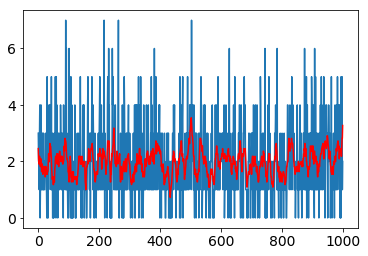

In [58]:
#%%time

#def poisson_spks_ms(t, r, rp):
# returns an array of spike times discretized to 1 ms in time
# assume 1 ms binning; t in ms
# r - poisson spike rate in Hz
# rp - refractory period in ms
#    numbers=np.random.uniform(size=t)
#    temp=np.where(numbers < r/1000.0)[0] # note: np.where returns a tuple
#    ind=np.where(np.diff(temp)>rp)[0] # find isis longer than refractory period
#    temp=temp[np.append(ind, len(temp)-1)]
#    return temp

#def poisson_spks_ms(t, r, rp):
# returns an array of spike times discretized to 1 ms in time
# assume 1 ms binning; t in ms
# r - poisson spike rate in Hz
# rp - refractory period in ms
#    numbers=np.random.uniform(size=t)
#    temp=np.where(numbers < r/1000.0)[0] # note: np.where returns a tuple
#    if len(temp > 0):
#        ind=np.where(np.diff(temp)>rp)[0] # find isis longer than refractory period
#        temp=temp[np.append(ind, len(temp)-1)]
#    return temp


trials = 1000
duration = 10000 # trial duration in ms
refractory_period = 5 # in ms
rate =2 # in Hz

spk_trains = []
for ii in np.arange(trials):
    spks = sim_spks.poisson_spks_ms(duration, rate, refractory_period)
#    plt.plot(spks, (ii+1)*np.ones(len(spks)), 'k.')
    spk_trains.append(spks)

    # peristimulus time histogram
all_spks=np.array([])
for spks in spk_trains:
    all_spks=np.append(all_spks, spks)

bins=np.arange(10000)+0.5
(hg, bin_edges)=np.histogram(all_spks, bins)

plt.plot(bin_edges[0:1000], hg[0:1000])
plt.plot(bin_edges[0:1000], sp.smooth1D(hg[0:1000], window='flat'), 'r')

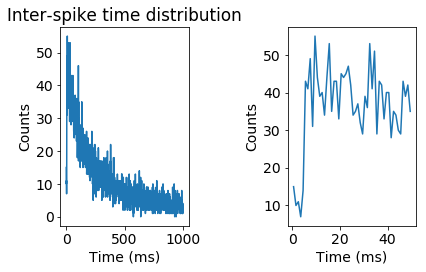

In [78]:
# Compute isi histogram function 

all_isi=np.array([])
for spks in spk_trains:
    all_isi=np.append(all_isi, np.diff(spks))

bins=np.arange(10000)+0.5
(hg, bin_edges)=np.histogram(all_isi, bins)

plt.subplot(1, 2, 1)
plt.plot(bin_edges[0:1000], hg[0:1000])  
plt.ylabel('Counts')
plt.xlabel('Time (ms)')
plt.ylabel('Counts')
plt.title('Inter-spike time distribution')

plt.subplot(1, 2, 2)
plt.plot(bin_edges[0:50], hg[0:50])
plt.ylabel('Counts')
plt.xlabel('Time (ms)')
plt.tight_layout()


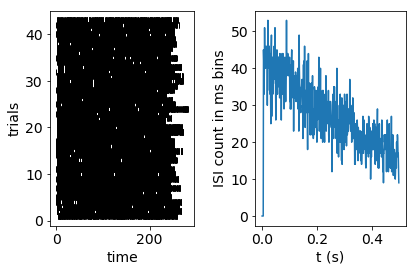

In [93]:
# alternative way to produce poisson spike trains
# using the exponential distribution

import numpy as np
import matplotlib.pyplot as plt

alpha=.5 # time constant; 1/rate
npts=22000 #
refractory_period = 0.005 # s 
#runs=10 #

isi=np.random.exponential(scale=alpha,size=(npts))

# find short isis and remove them -- i.e. refractory period
shorts=np.where(isi < refractory_period)
isi=np.delete(isi, shorts)

sp_times=np.cumsum(isi)

#sp_times=sim_spks.poisson_spks_ms(npts, 2.0, 5)

plt.rcParams.update({'font.size': 14})  # increase the font size
ax=plt.subplot(1, 2, 1)
plt.xlabel("time")
plt.ylabel("trials")

delta=0
last=0
rast=500
while (rast + delta*rast) < len(sp_times): 
    spks = sp_times[(0+rast*delta):(rast+rast*delta)]-last
    plt.plot(spks, (delta+1)*np.ones(len(spks)), 'k|')
    last=last+spks[-1]
    delta+=1
ax.set_aspect(aspect=10.0)
    
plt.subplot(1, 2, 2)

bins=np.arange(0, 1, 0.001)
(hg, bin_edges)=np.histogram(isi, bins)

plt.rcParams.update({'font.size': 14})  # increase the font size
plt.xlabel("t (s)")
plt.ylabel("ISI count in ms bins")

plt.plot(bin_edges[0:500], hg[0:500])
plt.tight_layout()


# Spike sorting metrics: what do they mean?


Here we consider a standard spike sorting quality metric $Q$, corresponding to the proportion of spikes in refractory period $T_r$. What does this mean in terms of false positive rates $fp$?

Let $r_o$ be the rate of the primary neuron and $r_1$ the rate of detection of the polluting neurons by the spike sorting system, $r_1=\sum r_i$ (all Poisson neurons). Then the total spikes produced by these neurons in interval $T$ is $N_o = r_oT$ and $N_1=r_1T$. 

Now, the probability of a spike from the polluting neurons in $T_r$ after a spike from the primary neuron is $p_1=r_1T_r$. Therefore the number of spikes in Tr following spikes from the primary neuron is 
$$n_o=r_1T_rr_oT$$
Similarly, the number of spikes in Tr following spikes from the polluting neuron is 
$$n_1=r_oT_rr_1T$$
The number of counts in the refractory period is the sum:
$$n_r=2r_or_1TT_r$$

The spike sorting quality metric is:

$$Q=\frac{n_r}{N_o+N_1}= \frac{2r_or_1T_r}{r_o+r_1}$$

The false positive rate is 

$$fp=\frac{N_1}{N_1+N_o}=\frac{r_1}{r_1+r_o}$$

Therefore,

$$fp=\frac{Q}{2r_oT_r}$$

For example, assume $Q = 0.01$, $r_o=5Hz$ and $T_r=5 ms$, then $fp=0.2$. Pretty bad. Q should probably be in the 0.001 regime. 

Q =  0.01020169768709602
fp rate =  0.5
count in rp n_r = 393 ; expected n_r =  400.0


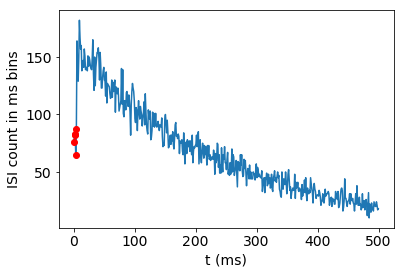

In [60]:
trials = 1000
duration = 10000 # trial duration in ms
rp = 5 # in ms
rate0 =2.0 # in Hz
rate1 =2.0 # in Hz; polluting spikes

spk_trains = []
for ii in np.arange(trials):
    spks=sim_spks.poisson_spks_ms(duration, rate0, rp)
    spks=np.append(spks, sim_spks.poisson_spks_ms(duration, rate1, rp))
    spks=np.sort(spks)
    #    plt.plot(spks, (ii+1)*np.ones(len(spks)), 'k.')
    spk_trains.append(spks)

all_isi=np.array([])
for spks in spk_trains:
    all_isi=np.append(all_isi, np.diff(spks))

bins=np.arange(10000)+0.5
(hg, bin_edges)=np.histogram(all_isi, bins)

plt.rcParams.update({'font.size': 14})  # increase the font size
plt.xlabel("t (ms)")
plt.ylabel("ISI count in ms bins")

plt.plot(bin_edges[0:500], hg[0:500])
plt.plot(bin_edges[0:5], hg[0:5],'ro')

print('Q = ', np.sum(hg[0:5])/np.sum(hg))
print('fp rate = ',rate1/(rate0+rate1))
print('count in rp n_r =', np.sum(hg[0:round(rp)]), '; expected n_r = ', 
      2*rate0*rate1*trials*duration*rp/(1000*1000))    

# Some thoughts on highly modulated spike trains

Things can get pretty crazy if we allow spike trains to be modulated in time. In the example below, we have the situation where half the spikes are contributed by a neuron (or neurons) that fire only for 1/10 of the trial (i.e. a higly modulated unit). Note that the PSTH shows strong modulation where there should be none, yet Q is very low.

Here $r_1(t) = r_1$ when $t\in{(t_o, t_o+\Delta T)}$ and $r_1(t) = 0$ elsewhere. 

Then $n_r=2 r_o r_1 T_r\Delta T $ and $ Q= \frac{2 r_o r_1 T_r\Delta T}{r_o+r_1}$ and $fp = \frac{r_1}{r_1+r_o\frac {T}{\Delta T}} $

With highly modulated polluting units it is easy to have low Q and terrible fp rate as well as spurious modulation.

This suggests that low Q is not a terribly useful metric for quality of spike sorting. 




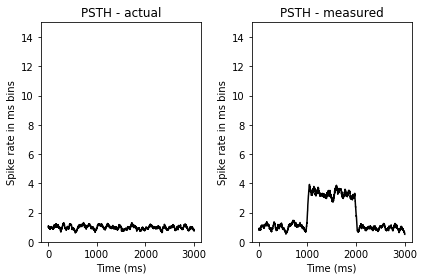

In [88]:
# new problem
# now let's assume that we have a strongly modulated background unit at mean rate r_1
trials = 1000
duration0 = 10001 # trial duration in ms
duration1 = 1000 # duration of high activity, from 1-2 sec; low otherwise 
rp = 5 # in ms
rate0 =1.0 # in Hz
rate1 =2.0 # in Hz; polluting spikes

spk_trains = []
spk_trains0 = []
for ii in np.arange(trials):
    spks0=sim_spks.poisson_spks_ms(duration0, rate0, rp)
    spk_trains0.append(spks0)
    spks1=sim_spks.poisson_spks_ms(duration1, rate1, rp)
    if len(spks1)>0:
        spks=np.append(spks0, (1000.0+spks1)) 
        # Polluting unit produced high spike rates for 1 s with 1 s delay 
        spks=np.sort(spks)
    #    plt.plot(spks, (ii+1)*np.ones(len(spks)), 'k.')
    spk_trains.append(spks)

all_spks=np.array([])
for spks in spk_trains:
    all_spks=np.append(all_spks, spks)

all_spks0=np.array([])
for spks0 in spk_trains0:
    all_spks0=np.append(all_spks0, spks0)

bins=np.arange(100001)+0.5
(hg, bin_edges)=np.histogram(all_spks, bins)
(hg0, bin_edges)=np.histogram(all_spks0, bins)

plt.rcParams.update({'font.size': 10})  # increase the font size
plt.subplot(1, 2, 1)
plt.ylim(0, 15)
plt.xlabel("Time (ms)")
plt.ylabel("Spike rate in ms bins")
plt.title('PSTH - actual')
plt.plot(bin_edges[0:3000], sp.smooth1D(hg0[0:3000], window_len=51, window='flat'), 'k')

plt.subplot(1, 2, 2)
plt.ylim(0, 15)
plt.xlabel("Time (ms)")
plt.ylabel("Spike rate in ms bins")
plt.title('PSTH - measured')
plt.plot(bin_edges[0:3000], sp.smooth1D(hg[0:3000], window_len=51, window='flat'), 'k') 
plt.tight_layout()


Q =  0.0021106323102629498
fp rate =  0.16665277893508876
count in rp n_r = 24 ; expected n_r =  20.0


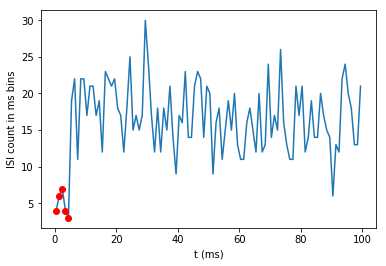

In [89]:
all_isi=np.array([])
for spks in spk_trains:
    all_isi=np.append(all_isi, np.diff(spks))

bins=np.arange(10000)+0.5
(hg, bin_edges)=np.histogram(all_isi, bins)

plt.plot(bin_edges[0:100], hg[0:100])
plt.plot(bin_edges[0:5], hg[0:5],'ro')

plt.rcParams.update({'font.size': 14})  # increase the font size
plt.xlabel("t (ms)")
plt.ylabel("ISI count in ms bins")

print('Q = ', np.sum(hg[0:5])/np.sum(hg))
print('fp rate = ',rate1/(rate0*(duration0/duration1)+rate1))
print('count in rp n_r =', np.sum(hg[0:round(rp)]), '; expected n_r = ', 
      2*rate0*rate1*trials*duration1*rp/(1000*1000)) 

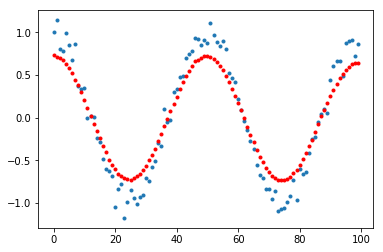

In [14]:

t=np.linspace(0,4*np.pi, 100)
y=np.cos(t)+0.1*np.random.randn(100)
ys=sp.smooth1D(y, window_len=21, window='flat')
plt.plot(y, '.')
plt.plot(ys, '.r')


In [7]:
import sys
sys.path.append("../") # go to parent dir
from custom_funcs import smooth1D

In [13]:
pwd

'/Users/svobodak/Dropbox (HHMI)/_work/python_work/various_notebooks'

In [35]:
len([])

0

In [49]:
b=1
if type(b) == 'int':
    print('hi')

In [71]:
sim_spks.poisson_spks_ms(1000, 1.3, round(1.4))

array([986])

In [73]:
r=5
s=2
r/s

2.5